In [45]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa
import IPython.display as ipd
import matplotlib.ticker as ticker
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

sys.path.append('../src')
from dataset import SC09MixtureDataset
from models import NVAE
from utils import bss_eval

CHECKPOINTS_PATH = '/home/karamatli/checkpoints'
EXPERIMENTS_PATH = '/home/karamatli/experiments'

In [5]:
def load_test_results(name, training, partition='testing', step=None):
    results_dir = os.path.join(EXPERIMENTS_PATH, name, training, 'test', partition)
    if step:
        path = os.path.join(results_dir, '{:06d}.pth'.format(step))
    else:
        filenames = os.listdir(results_dir)
        if len(filenames) != 1:
            raise Exception()
        path = os.path.join(results_dir, filenames[0])
    results = torch.load(path)
    sdr = results[:, 0, :].reshape(-1)
    sir = results[:, 1, :].reshape(-1)
    sar = results[:, 2, :].reshape(-1)
    return sdr, sir, sar

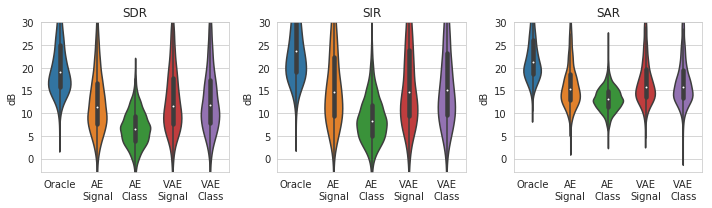

In [50]:
def plot_compare_ae_vae_source_label():
    sdr0, sir0, sar0 = load_test_results('oracle', '')
    sdr1, sir1, sar1 = load_test_results('compare_ae_vae_source_label', 'sc09mix-cl10-cm2-nt15000-source-bs100-ls128-hs128-b10-ae')
    sdr2, sir2, sar2 = load_test_results('compare_ae_vae_source_label', 'sc09mix-cl10-cm2-nt15000-label-bs100-ls128-hs128-b10-ae')
    sdr3, sir3, sar3 = load_test_results('compare_ae_vae_source_label', 'sc09mix-cl10-cm2-nt15000-source-bs100-ls128-hs128-b10-vae')
    sdr4, sir4, sar4 = load_test_results('compare_ae_vae_source_label', 'sc09mix-cl10-cm2-nt15000-label-bs100-ls128-hs128-b10-vae')

    df_sdr = pd.DataFrame({
        'Oracle' : sdr0,
        'AE\nSignal' : sdr1,
        'AE\nClass' : sdr2,
        'VAE\nSignal' : sdr3,
        'VAE\nClass' : sdr4,
    })

    df_sir = pd.DataFrame({
        'Oracle' : sir0,
        'AE\nSignal' : sir1,
        'AE\nClass' : sir2,
        'VAE\nSignal' : sir3,
        'VAE\nClass' : sir4,
    })

    df_sar = pd.DataFrame({
        'Oracle' : sar0,
        'AE\nSignal' : sar1,
        'AE\nClass' : sar2,
        'VAE\nSignal' : sar3,
        'VAE\nClass' : sar4,
    })

    def violin(df):
        ax = sns.violinplot(data=df)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        plt.ylim(-3, 30)
        plt.ylabel('dB')

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.title('SDR')
        violin(df_sdr)
        plt.subplot(1, 3, 2)
        plt.title('SIR')
        violin(df_sir)
        plt.subplot(1, 3, 3)
        plt.title('SAR')
        violin(df_sar)
        plt.tight_layout()
        plt.savefig('/tmp/compare_ae_vae_source_label.pdf', bbox_inches='tight', pad_inches=0)
plot_compare_ae_vae_source_label()

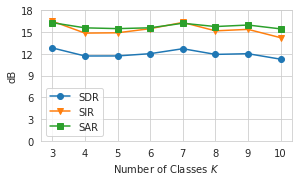

In [44]:
def plot_vary_num_classes():
    class_count_list = []
    sdr_list = []
    sir_list = []
    sar_list = []

    def load_test_results_internal(class_count, class_start):
        return load_test_results('vary_num_classes', 'sc09mix-cl%d_%d-cm2-nt15000-label-bs100-ls128-hs128-b10-vae' % (class_count, class_start))

    for class_count in range(3, 11):
        if class_count == 3:
            sdr = np.empty(0)
            sir = np.empty(0)
            sar = np.empty(0)
            for class_start in [0, 3, 6]:
                sdr_single, sir_single, sar_single = load_test_results_internal(class_count, class_start)
                sdr = np.concatenate((sdr, sdr_single))
                sir = np.concatenate((sir, sir_single))
                sar = np.concatenate((sar, sar_single))
        else:
            sdr, sir, sar = load_test_results_internal(class_count, class_start=0)
        class_count_list.append(class_count)
        sdr_list.append(np.median(sdr))
        sir_list.append(np.median(sir))
        sar_list.append(np.median(sar))

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(4.5, 2.4))
        plt.plot(class_count_list, sdr_list, '-o')
        plt.plot(class_count_list, sir_list, '-v')
        plt.plot(class_count_list, sar_list, '-s')
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))
        plt.ylim(0, 18)
        plt.xlabel('Number of Classes $K$')
        plt.ylabel('dB')
        plt.legend(('SDR', 'SIR', 'SAR'))
        plt.savefig('/tmp/vary_num_classes.pdf', bbox_inches='tight', pad_inches=0)

plot_vary_num_classes()

tensor([0, 5])


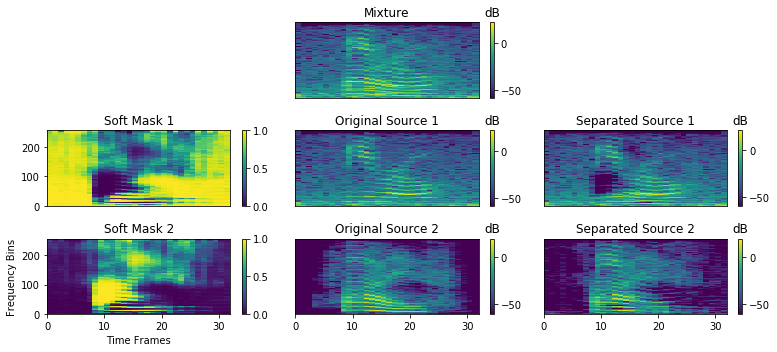

In [58]:
def plot_vae(dataset_name, experiment_name, training_name, step, idx):
    mixture_dataset = SC09MixtureDataset(os.path.join(EXPERIMENTS_PATH, 'datasets', dataset_name), partition='validation')

    class SingleMixtureDataset(Dataset):
        def __len__(self):
            return 1

        def __getitem__(self, _):
            return mixture_dataset[idx]

    mixture_dataloader = DataLoader(SingleMixtureDataset(), batch_size=1, shuffle=True)

    nvae = NVAE.load(path=os.path.join(EXPERIMENTS_PATH, experiment_name, training_name, 'train','{:06d}.pth'.format(step)),
                     device='cpu')

    samples = next(iter(mixture_dataloader))
    x = samples['magnitude']
    sources = samples['sources']
    phase = samples['phase']

    nvae.forward(x_mix=x,
                 x_src=SC09MixtureDataset.sources_to_magnitudes(sources),
                 y_sparse=samples['labels'],
                 train=False)

    pred_x_src_masked, pred_x_src_mask = nvae.batch_p_x_src_masked()
    pred_x_src_masked = pred_x_src_masked.detach()
    pred_x_src_mask = pred_x_src_mask.detach()

    print(samples['labels'][0])

    def plot(title, data, cb_title='dB', vmin=None, vmax=None, xaxis=False, yaxis=False):
        plt.title(title)
        plt.pcolormesh(data, vmin=vmin, vmax=vmax)
        cb = plt.colorbar()
        if cb_title:
            cb.ax.set_title(cb_title)
        plt.gca().axes.get_xaxis().set_visible(xaxis)
        plt.gca().axes.get_yaxis().set_visible(yaxis)

    plt.figure(figsize=(11,5))

    plt.subplot(3, 3, 2)
    plot(title='Mixture',
         data=librosa.core.amplitude_to_db(x[0].detach().t()))

    plt.subplot(3, 3, 4)
    plot(title='Soft Mask 1',
         data=pred_x_src_mask[0, 0].detach().t(),
         cb_title=None,
         vmin=0,
         vmax=1,
         yaxis=True)

    plt.subplot(3, 3, 7)
    plot(title='Soft Mask 2',
         data=pred_x_src_mask[0, 1].detach().t(),
         cb_title=None,
         vmin=0,
         vmax=1,
         xaxis=True,
         yaxis=True)
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')

    plt.subplot(3, 3, 5)
    plot(title='Original Source 1',
         data=librosa.core.amplitude_to_db(sources[0]['magnitude'][0].t()))

    plt.subplot(3, 3, 8)
    plot(title='Original Source 2',
         data=librosa.core.amplitude_to_db(sources[1]['magnitude'][0].t()),
         xaxis=True)

    plt.subplot(3, 3, 6)
    plot(title='Separated Source 1',
         data=librosa.core.amplitude_to_db(pred_x_src_masked[0, 0].detach().t()))

    plt.subplot(3, 3, 9)
    plot(title='Separated Source 2',
         data=librosa.core.amplitude_to_db(pred_x_src_masked[0, 1].detach().t()),
         xaxis=True)

    plt.tight_layout()
    plt.savefig('/tmp/example.png', bbox_inches='tight', pad_inches=0)

plot_vae(dataset_name='sc09mix-cl10-cm2-nt15000',
         experiment_name='compare_ae_vae_source_label',
         training_name='sc09mix-cl10-cm2-nt15000-label-bs100-ls128-hs128-b10-vae',
         step=29199,
         idx=859)

In [4]:
nvae = NVAE.load(path=os.path.join('/home/karamatli/checkpoints/wlssc-sc09', 'train','{:06d}.pth'.format(14799)),
                          device='cpu')
nvae.supervision

'label'

2.470332738369052e-08 0.17114004492759705 18.740720748901367
9.45426376075531e-11 0.0874820351600647 7.460884094238281


/home/karamatli/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


tensor([7, 8])


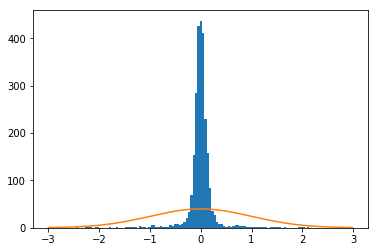

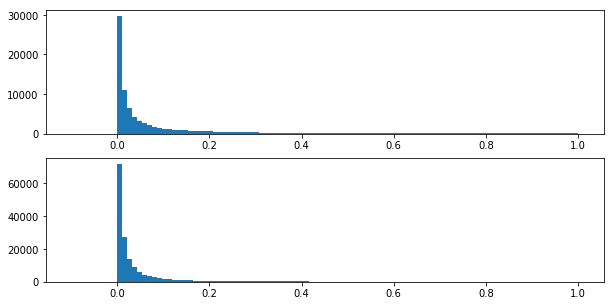

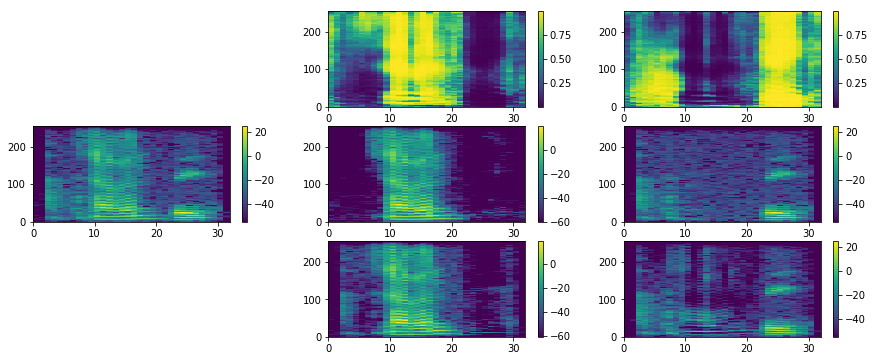

[[21.85197427 16.78215662]
 [34.02571047 18.04138056]
 [22.12528632 22.84102846]]


tensor([4, 9])


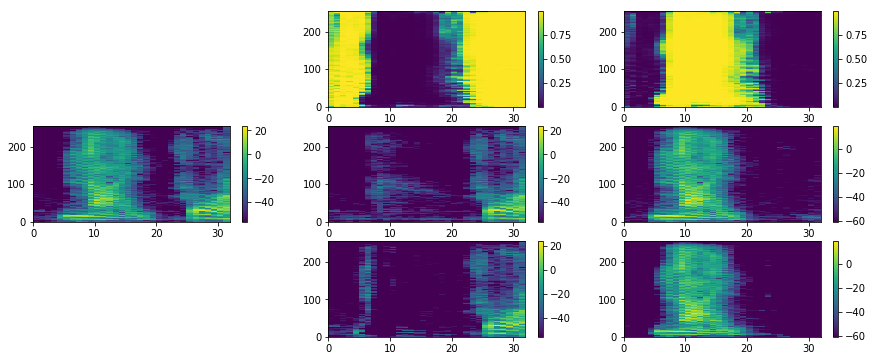

[[29.06478332 29.31721086]
 [40.74371914 52.08137142]
 [29.37069661 29.34027973]]


tensor([3, 7])


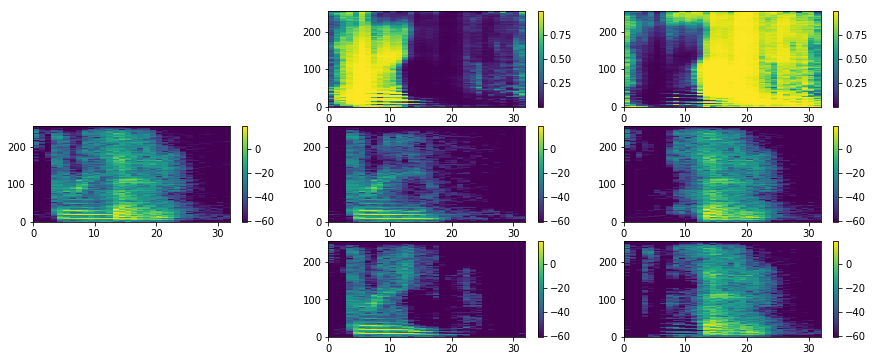

[[11.42758645 13.23559174]
 [13.29090769 17.35767821]
 [16.19988732 15.44057273]]


tensor([2, 6])


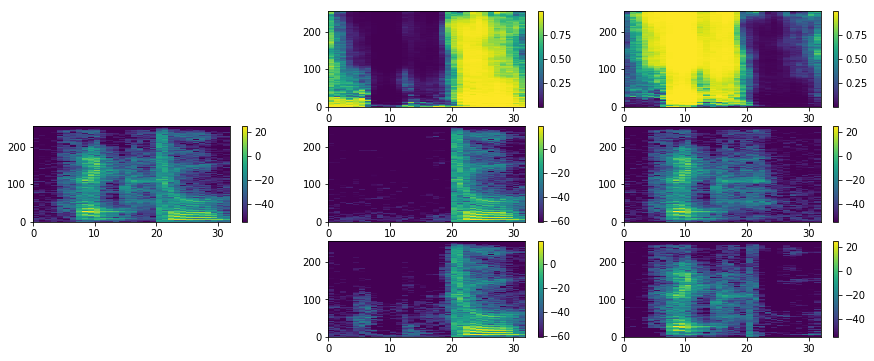

[[28.20204169 25.97022614]
 [40.27817544 29.53333004]
 [28.48041729 28.49504132]]


tensor([2, 7])


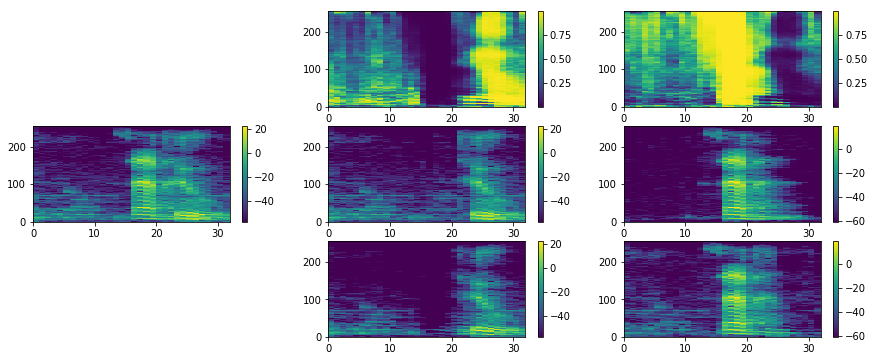

[[18.01122168 18.87690118]
 [22.24450735 24.59227904]
 [20.09416497 20.24804898]]


tensor([0, 3])


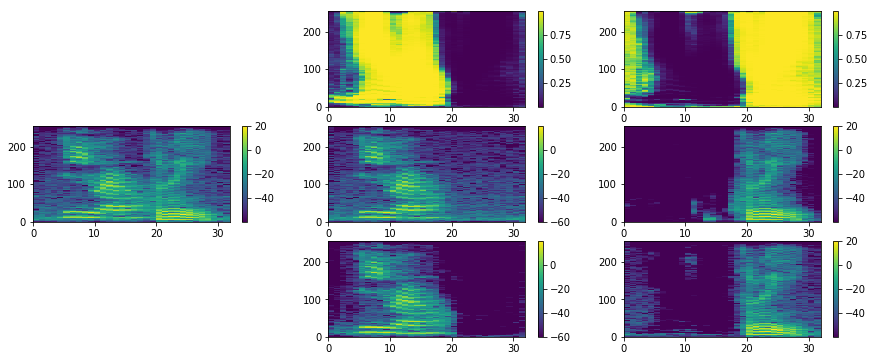

[[26.43912568 25.9964796 ]
 [37.73666594 33.94303216]
 [26.77455864 26.75777497]]


tensor([0, 7])


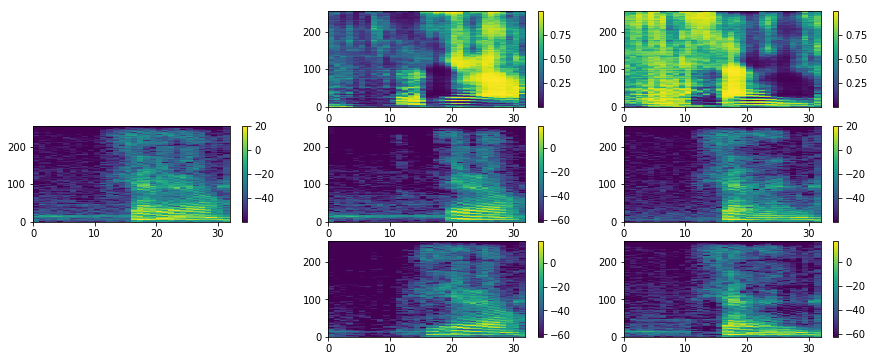

[[ 8.18905565  6.6734987 ]
 [10.49127013  7.93436741]
 [12.41730883 13.3077937 ]]


tensor([4, 6])


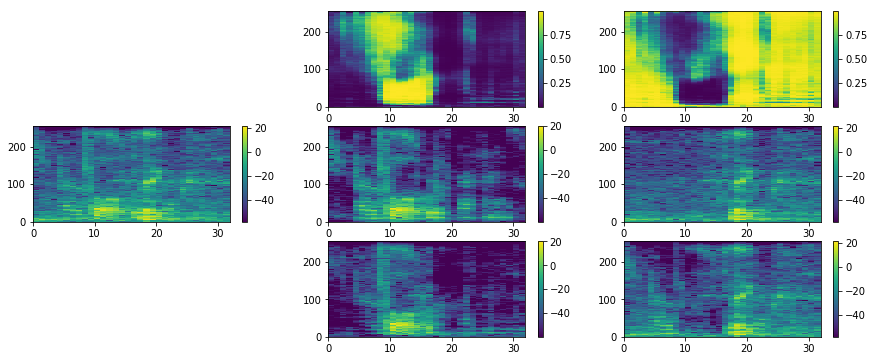

[[11.40512796  9.84581359]
 [24.98442484 13.44950301]
 [11.61367497 12.52609612]]


tensor([2, 4])


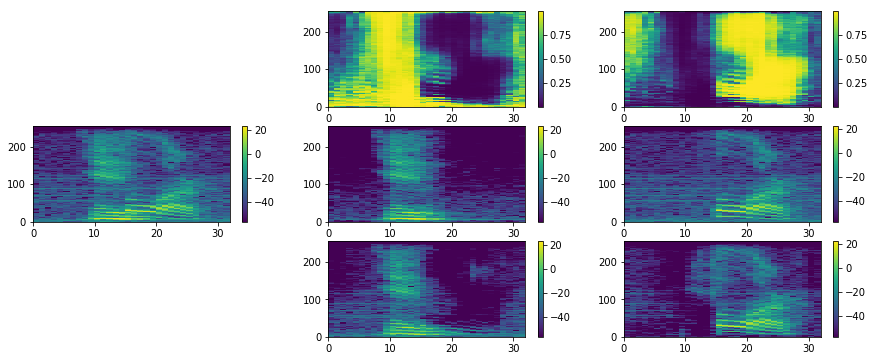

[[20.66819934 21.9062912 ]
 [23.72798136 27.35837584]
 [23.64794291 23.3709899 ]]


tensor([4, 5])


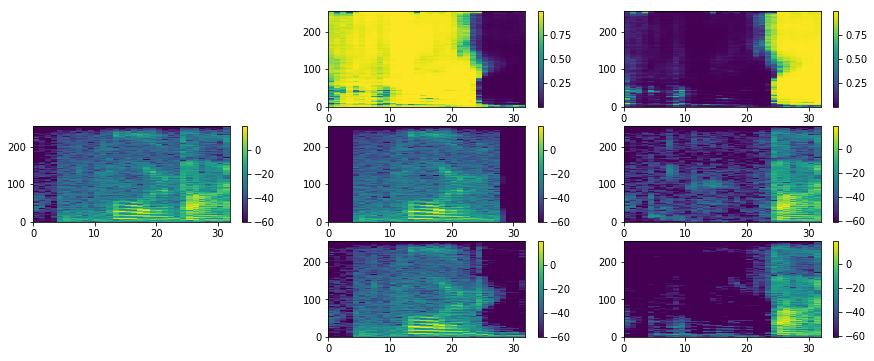

[[18.79386789 21.64856194]
 [21.40864911 32.56075229]
 [22.27063568 22.01807539]]


In [4]:
batch_size = 10
mixture_dataset = SC09MixtureDataset('/home/karamatli/datasets/sc09-cl10-cm2-nt15000', partition='validation')

def plot_vae_multi(name, step):
    mixture_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)

    nvae = NVAE.load(path=os.path.join('/home/karamatli/experiments', name, 'train','{:06d}.pth'.format(step)),
                          device='cpu')

    for i, samples in enumerate(mixture_dataloader):
        x = samples['magnitude']
        y_sparse = samples['labels']
        sources = samples['sources']
        phase = samples['phase']

        nvae.forward(x_mix=x,
                     y_sparse=y_sparse,
                     x_src=SC09MixtureDataset.sources_to_magnitudes(samples['sources']),
                     train=False)

        plt.hist(nvae.batch_q_mu[:,:,:].view(-1), bins=100)
        norm_x = np.arange(-3, 3, 0.01)
        plt.plot(norm_x, norm.pdf(norm_x)*100)
        #plt.pcolormesh(z)

        print(x.min().item(), x.mean().item(), x.max().item())
        print(nvae.batch_p_x_src.min().item(), nvae.batch_p_x_src.mean().item(), nvae.batch_p_x_src.max().item())

        plt.figure(figsize=(10,5))
        plt.subplot(2, 1, 1)
        plt.hist(x.view(-1), bins=100, range=(-0.1, 1))
        plt.subplot(2, 1, 2)
        plt.hist(nvae.batch_p_x_src.view(-1), bins=100, range=(-0.1, 1))

        #x_db = torch.FloatTensor(librosa.core.amplitude_to_db(x.cpu().detach()))
        #x[x_db<-50] = 0

        ref_waves = SC09MixtureDataset.sources_to_waves(sources).numpy()
        pred_x_src_masked, pred_x_src_mask = nvae.batch_p_x_src_masked()
        pred_x_src_masked = pred_x_src_masked.detach()
        pred_x_src_mask = pred_x_src_mask.detach()
        pred_waves = SC09MixtureDataset.magnitudes_to_waves(pred_x_src_masked.numpy(), phase)
        results = bss_eval(ref_waves, pred_waves)

        for idx in range(batch_size):
            print(samples['labels'][idx])
            plt.figure(figsize=(15,6))
            plt.subplot(3, 3, 2)
            plt.pcolormesh(pred_x_src_mask[idx, 0].detach().t())
            plt.colorbar()
            plt.subplot(3, 3, 3)
            plt.pcolormesh(pred_x_src_mask[idx, 1].detach().t())
            plt.colorbar()
            plt.subplot(3, 3, 4)
            plt.pcolormesh(librosa.core.amplitude_to_db(x[idx].detach().t()))
            plt.colorbar()
            plt.subplot(3, 3, 5)
            plt.pcolormesh(librosa.core.amplitude_to_db(sources[0]['magnitude'][idx].t()))
            plt.colorbar()
            plt.subplot(3, 3, 6)
            plt.pcolormesh(librosa.core.amplitude_to_db(sources[1]['magnitude'][idx].t()))
            plt.colorbar()
            plt.subplot(3, 3, 8)
            plt.pcolormesh(librosa.core.amplitude_to_db(pred_x_src_masked[idx, 0].detach().t()))
            plt.colorbar()
            plt.subplot(3, 3, 9)
            plt.pcolormesh(librosa.core.amplitude_to_db(pred_x_src_masked[idx, 1].detach().t()))
            plt.colorbar()
            plt.show()

            source_pred = np.stack([SC09MixtureDataset.magnitude_to_wave(pred_x_src_masked[idx, 0].numpy(), phase[idx]),
                                    SC09MixtureDataset.magnitude_to_wave(pred_x_src_masked[idx, 1].numpy(), phase[idx])])

            print(results[idx])
            ipd.display(ipd.Audio(data=SC09MixtureDataset.magnitude_to_wave(x[idx].numpy(), phase[idx]), rate=SC09MixtureDataset.SAMPLE_RATE))
            ipd.display(ipd.Audio(data=source_pred[0], rate=SC09MixtureDataset.SAMPLE_RATE))
            ipd.display(ipd.Audio(data=source_pred[1], rate=SC09MixtureDataset.SAMPLE_RATE))
        break

plot_vae_multi('compare_ae_vae_source_label/sc09mix-cl10-cm2-nt15000-label-bs100-ls128-hs128-b10-vae', 29199)